
# View Lucid Dreaming Core Session Data

This notebook loads and visualizes data recorded by the `app/main.py` application.
It reads the `session_metadata.npz` file for session information and then loads the corresponding
`eeg_eog_data.dat` and `aux_sensor_data.dat` binary files.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from frenztoolkit.reader import load_experiment

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

# --- Configuration & Session Selection ---
BASE_RECORDING_FOLDER = "app/recorded_data"
METADATA_FILENAME = "session_metadata.npz"
EEG_EOG_DATA_FILENAME = "eeg_eog_data.dat"
AUX_SENSOR_DATA_FILENAME = "aux_sensor_data.dat"
EEG_DATA_TYPE = np.float32 # Should match what's in main.py

def list_session_folders(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Base recording folder not found: {base_folder}")
        return []
    sessions = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))], reverse=True)
    return sessions

available_sessions = list_session_folders(BASE_RECORDING_FOLDER)
if not available_sessions:
    print(f"No session folders found in {BASE_RECORDING_FOLDER}")
else:
    print("Available sessions:")
    for i, session_id in enumerate(available_sessions):
        print(f"{i}: {session_id}")
    
    # Select a session (e.g., the latest one)
    selected_session_index = 0 # Or use input() for user to choose
    if 0 <= selected_session_index < len(available_sessions):
        SESSION_FOLDER_NAME = available_sessions[selected_session_index]
        SESSION_PATH = os.path.join(BASE_RECORDING_FOLDER, SESSION_FOLDER_NAME)
        print(f"\nSelected session: {SESSION_FOLDER_NAME}")
        print(f"Session path: {SESSION_PATH}")
    else:
        print("Invalid session index selected.")
        SESSION_PATH = None

Available sessions:
0: 20250529_143952_050480
1: 20250527_000831_104560
2: 20250527_000757_939346
3: 20250526_234715_701464
4: 20250526_223152_730954
5: 20250526_205851_353747
6: 20250520_230403_168461
7: 20250520_223611_155605

Selected session: 20250529_143952_050480
Session path: app/recorded_data/20250529_143952_050480


In [3]:

# --- Load Metadata --- 
metadata = None
if SESSION_PATH and os.path.isdir(SESSION_PATH):
    metadata_filepath = os.path.join(SESSION_PATH, METADATA_FILENAME)
    if os.path.exists(metadata_filepath):
        try:
            metadata = np.load(metadata_filepath, allow_pickle=True)
            print("\n--- Session Metadata ---")
            for key, value in metadata.items():
                if key not in ['scores', 'eeg_eog_data_info', 'aux_sensor_data_info'] and not key.startswith("metadata_"):
                    print(f"{key}: {value}")
            
            if 'eeg_eog_data_info' in metadata:
                print("\nEEG/EOG Data Info:")
                for k,v in metadata['eeg_eog_data_info'].item().items(): # .item() if it's a 0-d array object
                    print(f"  {k}: {v}")
            if 'aux_sensor_data_info' in metadata:
                print("\nAuxiliary Sensor Data Info:")
                for k,v in metadata['aux_sensor_data_info'].item().items():
                    print(f"  {k}: {v}")
            
            # Store for later use
            eeg_eog_info = metadata['eeg_eog_data_info'].item() if 'eeg_eog_data_info' in metadata else None
            aux_info = metadata['aux_sensor_data_info'].item() if 'aux_sensor_data_info' in metadata else None
            sampling_frequency = metadata['sampling_frequency_hz'].item() if 'sampling_frequency_hz' in metadata else 250.0

        except Exception as e:
            print(f"Error loading metadata file {metadata_filepath}: {e}")
            metadata = None
    else:
        print(f"Metadata file not found: {metadata_filepath}")
else:
    print("Session path not set or invalid.")



--- Session Metadata ---
product_key: RUtYA4W3kpXi0i9C7VZCQJY5_GRhm4XL2rKp6cviwQI=
device_id: FRENZI40
session_start_iso: 2025-05-29T14:39:52.050480
sampling_frequency_hz: 125.0

EEG/EOG Data Info:
  filename: eeg_eog_data.dat
  data_type: float32
  channel_names: ['RAW_EEG_LF', 'RAW_EEG_OTEL', 'RAW_EEG_REF1', 'RAW_EEG_RF', 'RAW_EEG_OTER', 'RAW_EEG_REF2', 'FILT_EEG_LF', 'FILT_EEG_OTEL', 'FILT_EEG_RF', 'FILT_EEG_OTER', 'FILT_EOG_CH1', 'FILT_EOG_CH2', 'FILT_EOG_CH3', 'FILT_EOG_CH4']
  num_channels: 14
  shape_on_save: channels_first

Auxiliary Sensor Data Info:
  filename: aux_sensor_data.dat
  data_type: float32
  channel_names: ['FILT_EMG_CH1', 'FILT_EMG_CH2', 'FILT_EMG_CH3', 'FILT_EMG_CH4', 'RAW_IMU_X', 'RAW_IMU_Y', 'RAW_IMU_Z', 'RAW_PPG_GREEN', 'RAW_PPG_RED', 'RAW_PPG_IR']
  num_channels: 10
  shape_on_save: channels_first


In [4]:

# --- Function to Load .dat Files ---
def load_dat_file(filepath, num_channels, total_samples, dtype=np.float32):
    if not os.path.exists(filepath):
        print(f"Data file not found: {filepath}")
        return None
    try:
        data_flat = np.fromfile(filepath, dtype=dtype)
        # Expected number of elements
        expected_elements = num_channels * total_samples
        if data_flat.size != expected_elements:
            print(f"Warning: File size mismatch for {filepath}. Expected {expected_elements} elements, got {data_flat.size}.")
            # Attempt to reshape with actual elements, might lead to incorrect total_samples if file is corrupt/incomplete
            # For robust handling, one might need to adjust total_samples or num_channels based on data_flat.size
            # For now, we'll try to reshape with the number of samples that fits the channel count
            if data_flat.size % num_channels == 0:
                actual_total_samples = data_flat.size // num_channels
                if actual_total_samples != total_samples:
                    print(f"Adjusting total samples for {filepath} from {total_samples} to {actual_total_samples} based on file size.")
                total_samples = actual_total_samples
            else:
                print(f"Error: Cannot reshape data for {filepath} as size {data_flat.size} is not divisible by num_channels {num_channels}.")
                return None
        
        # Reshape to (num_channels, total_samples)
        # Data was written as (channels, samples_in_block).tobytes(), so it's C-contiguous.
        reshaped_data = data_flat.reshape(num_channels, total_samples)
        return reshaped_data
    except Exception as e:
        print(f"Error loading or reshaping data file {filepath}: {e}")
        return None


In [5]:

# --- Load EEG/EOG Data ---
eeg_eog_data_loaded = None
if metadata and eeg_eog_info and SESSION_PATH:
    eeg_eog_data_filepath = os.path.join(SESSION_PATH, EEG_EOG_DATA_FILENAME)
    num_eeg_eog_channels = eeg_eog_info['num_channels']
    
    if 'metadata_eeg_eog_sample_counts' in metadata:
        total_eeg_eog_samples = np.sum(metadata['metadata_eeg_eog_sample_counts'])
        if total_eeg_eog_samples > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, total_eeg_eog_samples, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(eeg_eog_data_filepath)
        expected_elements = file_size // (num_eeg_eog_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
        else:
            print("EEG/EOG sample counts not found in metadata.")


File size: 119973000 bytes, expected elements: 2142375

Loaded EEG/EOG data. Shape: (14, 2142375)


In [6]:
# --- Print First 5 Rows of EEG/EOG Data ---
if eeg_eog_data_loaded is not None:
    print("First 5 rows of EEG/EOG data (channels x samples):")
    print(eeg_eog_data_loaded[:4, :])
else:
    print("EEG/EOG data not loaded.")

First 5 rows of EEG/EOG data (channels x samples):
[[ 5.4127100e+05  5.4127100e+05  5.4127100e+05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 7.1258300e+05  7.1260900e+05  7.1262100e+05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.2861161e+00 -4.8832865e+00 -2.0220411e+00 ... -4.4608459e+00
  -5.1525278e+00 -4.4815555e+00]
 [ 4.0545410e+01  4.1057014e+01  3.0065136e+01 ... -2.1963367e-01
  -6.8802267e-01 -5.3874999e-01]]


In [7]:

# --- Load Auxiliary Sensor Data ---
aux_data_loaded = None
if metadata and aux_info and SESSION_PATH:
    aux_data_filepath = os.path.join(SESSION_PATH, AUX_SENSOR_DATA_FILENAME)
    num_aux_channels = aux_info['num_channels']
    
    if 'metadata_aux_sample_counts' in metadata:
        total_aux_samples = np.sum(metadata['metadata_aux_sample_counts'])
        if total_aux_samples > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, total_aux_samples, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("No Auxiliary sensor samples recorded according to metadata.")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(aux_data_filepath)
        expected_elements = file_size // (num_aux_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("Auxiliary sensor sample counts not found in metadata.")


File size: 85705000 bytes, expected elements: 2142625

Loaded Auxiliary sensor data. Shape: (10, 2142625)


In [8]:
# --- Print First 5 Rows of Auxiliary Sensor Data ---
if aux_data_loaded is not None:
    print("First 5 rows of Auxiliary sensor data (channels x samples):")
    print(aux_data_loaded[:5, :])
else:
    print("Auxiliary sensor data not loaded.")


First 5 rows of Auxiliary sensor data (channels x samples):
[[ 2.06644654e-01  1.42755464e-01 -4.46297526e-02 ...  3.97683764e+00
   4.82697105e+00  5.92509985e-01]
 [-1.37570775e+00  3.92720252e-01  3.67254901e+00 ... -1.86813068e+01
  -2.36221218e+01 -1.01366091e+00]
 [ 1.22553055e+02  6.49542847e+01  1.39673325e+02 ... -9.83513221e-02
  -1.77564204e-01 -4.91999909e-02]
 [-1.39408827e+00 -4.22793403e-02  9.86492217e-01 ... -7.06505999e-02
  -1.25980213e-01 -9.53455716e-02]
 [-2.08709381e+02 -2.07484375e+02 -2.14987503e+02 ... -1.08718750e+02
  -1.09484375e+02 -1.14231247e+02]]


Key 'scores' not found in metadata.

--- Attempting Fallback: Load Sleep Stages with Frenz Toolkit ---
Attempting to load Frenz experiment data from subfolder: app/recorded_data/20250529_143952_050480/1748543998.717119


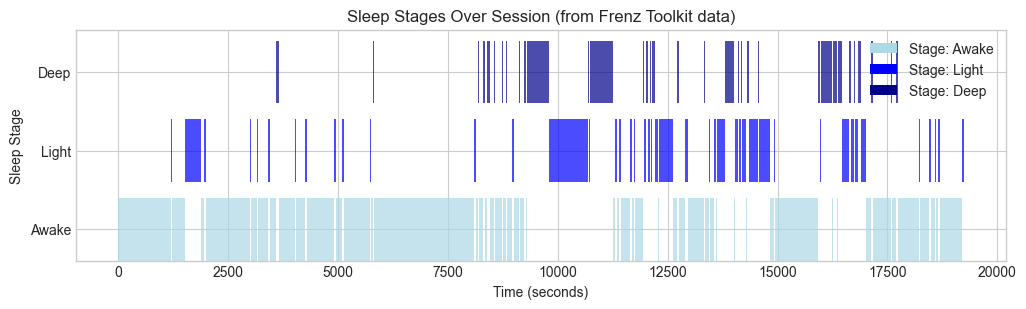

In [9]:
# data = load_experiment(
#     "app/recorded_data/20250528_184225_501675/1748472151.1818628")
# # If data is loaded, print some basic information

# print(len(data.get("DATA").get("RAW", {}).get("EEG", [])))
# print(len(data.get("SCORE").get("array__sleep_stage")))
# sleep_stages = data.get("SCORE").get("array__sleep_stage")
# loop through sleep stage and print if value is 3
# if sleep_stages is not None:
#     print("\n--- Sleep Stages from Frenz Toolkit Data ---")
#     for i, stage in enumerate(sleep_stages):
#         if stage == 3:  # REM sleep stage
#             print(f"Sleep Stage {i}: {stage} (REM)")

# get FRENZ_SESSION_PATH by SESSION_PATH and the folder (random name) within that folder
# we don't know the name of the folder, so we need to loop through and find the first folder
if SESSION_PATH and os.path.isdir(SESSION_PATH):
    for item in os.listdir(SESSION_PATH):
        item_path = os.path.join(SESSION_PATH, item)
        if os.path.isdir(item_path):
            FRENZ_SESSION_PATH = item_path
            break
data = load_experiment(FRENZ_SESSION_PATH)

# --- Display Scores and Audio Cues ---
if metadata and 'scores' in metadata and 'session_start_iso' in metadata:
    scores_dict = metadata['scores'].item()
    print(metadata['session_start_iso'])
    session_start_iso_str = str(metadata['session_start_iso'].item())
    audio_cue_timestamps_abs = metadata.get('audio_cue_timestamps')
    lrlr_detections_data = metadata.get('lrlr_detections')  # Load LRLR data

    # --- Plot Configuration ---
    AUDIO_CUE_PRE_DELAY_S = 5.0
    AUDIO_CUES_PER_SEQUENCE = 2
    PLOT_SLICE_START_S = None  # Or specify a start time in seconds, e.g., 0
    PLOT_SLICE_END_S = 160    # Or specify an end time in seconds, e.g., 1800
    SESSION_END_ISO_STR = None  # Provided session end time, set to None to use EEG sample based calculation
    # --- End Plot Configuration ---

    print("\n--- Saved Scores (from session_metadata.npz) ---")
    for score_name, score_array in scores_dict.items():
        if isinstance(score_array, np.ndarray) and score_array.size > 10:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'}), First 10 values: {score_array[:10]}")
        else:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'})")
            print(score_array)

    sleep_stages_all = scores_dict.get("array__sleep_stage")

    if sleep_stages_all is not None and hasattr(sleep_stages_all, '__len__') and len(sleep_stages_all) > 0:
        try:
            session_start_dt = datetime.fromisoformat(session_start_iso_str)
            session_start_timestamp = session_start_dt.timestamp()
            valid_start_time = True
        except ValueError:
            print(f"Error: session_start_iso '{session_start_iso_str}' is not a valid ISO format. Cannot calculate relative cue/LRLR times or adjusted interval from session end.")
            valid_start_time = False

        SLEEP_STAGE_INTERVAL_S = 30.0
        sleep_stage_time_axis_full_s = np.arange(len(sleep_stages_all)) * SLEEP_STAGE_INTERVAL_S

        # --- Apply Slicing for First Plot ---
        slice_indices = np.ones(len(sleep_stages_all), dtype=bool)

        # Determine xlim for the first plot
        xlim_start_orig = PLOT_SLICE_START_S if PLOT_SLICE_START_S is not None else (sleep_stage_time_axis_full_s[0] if len(sleep_stage_time_axis_full_s) > 0 else 0)
        xlim_end_orig = PLOT_SLICE_END_S if PLOT_SLICE_END_S is not None else (sleep_stage_time_axis_full_s[-1] + SLEEP_STAGE_INTERVAL_S if len(sleep_stage_time_axis_full_s) > 0 else 0)

        if PLOT_SLICE_START_S is not None:
            slice_indices &= (sleep_stage_time_axis_full_s + SLEEP_STAGE_INTERVAL_S > PLOT_SLICE_START_S)
        if PLOT_SLICE_END_S is not None:
            slice_indices &= (sleep_stage_time_axis_full_s < PLOT_SLICE_END_S)

        sleep_stages_orig_plot = sleep_stages_all[slice_indices]
        sleep_stage_time_axis_orig_plot_s = sleep_stage_time_axis_full_s[slice_indices]

        if len(sleep_stages_orig_plot) == 0:
            print(f"No sleep stage data in the selected slice for the original plot: {PLOT_SLICE_START_S}s - {PLOT_SLICE_END_S}s. Cannot plot.")
        else:
            print("\n--- Generating Original Plot (30s Interval) ---")
            plt.figure(figsize=(16, 8))  # Increased height for LRLR

            sleep_stage_colors = {
                -1: 'gray', 0: 'lightblue', 1: 'blue', 2: 'darkblue', 3: 'purple'
            }
            sleep_stage_labels = {
                -1: 'Undefined', 0: 'Awake', 1: 'Light', 2: 'Deep', 3: 'REM'
            }

            unique_stages_in_data = np.unique(sleep_stages_all)
            for stage_val in unique_stages_in_data:
                if stage_val in sleep_stage_labels:
                    plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")

            for i, stage in enumerate(sleep_stages_orig_plot):
                start_time = sleep_stage_time_axis_orig_plot_s[i]
                bar_width = SLEEP_STAGE_INTERVAL_S

                effective_bar_start = start_time
                if PLOT_SLICE_START_S is not None and start_time < PLOT_SLICE_START_S:
                    effective_bar_start = PLOT_SLICE_START_S
                    bar_width = (start_time + SLEEP_STAGE_INTERVAL_S) - PLOT_SLICE_START_S
                if PLOT_SLICE_END_S is not None and start_time + SLEEP_STAGE_INTERVAL_S > PLOT_SLICE_END_S:
                    if effective_bar_start == PLOT_SLICE_START_S:
                        bar_width = PLOT_SLICE_END_S - PLOT_SLICE_START_S if start_time < PLOT_SLICE_START_S else PLOT_SLICE_END_S - start_time
                    else:
                        bar_width = PLOT_SLICE_END_S - start_time

                if bar_width <= 0:
                    continue

                color = sleep_stage_colors.get(stage, 'black')
                plt.bar(effective_bar_start, bottom=stage-0.4, height=0.8, width=bar_width,
                        color=color, align='edge', alpha=0.7)

            current_ylim = plt.ylim()

            plotted_cues = False
            plotted_initiations = False
            if valid_start_time and audio_cue_timestamps_abs is not None and hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                if not isinstance(audio_cue_timestamps_abs, np.ndarray) or audio_cue_timestamps_abs.dtype != np.float64:
                    audio_cue_timestamps_abs = np.array(audio_cue_timestamps_abs, dtype=np.float64)

                relative_audio_cue_times_s_all = audio_cue_timestamps_abs - session_start_timestamp

                cue_slice_indices = (relative_audio_cue_times_s_all >= xlim_start_orig) & (relative_audio_cue_times_s_all <= xlim_end_orig)
                relative_audio_cue_times_s_plot = relative_audio_cue_times_s_all[cue_slice_indices]

                if len(relative_audio_cue_times_s_plot) > 0:
                    plt.vlines(relative_audio_cue_times_s_plot, ymin=current_ylim[0], ymax=current_ylim[1],
                               colors='red', linestyles='dashed', label='Audio Cue Fired', zorder=5, alpha=0.8)
                    plotted_cues = True

                audio_cue_initiation_times_s_all = []
                if len(relative_audio_cue_times_s_all) >= AUDIO_CUES_PER_SEQUENCE:
                    for i in range(0, len(relative_audio_cue_times_s_all), AUDIO_CUES_PER_SEQUENCE):
                        if i < len(relative_audio_cue_times_s_all):
                            first_cue_in_sequence_time = relative_audio_cue_times_s_all[i]
                            initiation_time = first_cue_in_sequence_time - AUDIO_CUE_PRE_DELAY_S
                            audio_cue_initiation_times_s_all.append(initiation_time)

                initiation_slice_indices = (np.array(audio_cue_initiation_times_s_all) >= xlim_start_orig) & (np.array(audio_cue_initiation_times_s_all) <= xlim_end_orig)
                audio_cue_initiation_times_s_plot = np.array(audio_cue_initiation_times_s_all)[initiation_slice_indices]

                if len(audio_cue_initiation_times_s_plot) > 0:
                    plt.vlines(audio_cue_initiation_times_s_plot, ymin=current_ylim[0], ymax=current_ylim[1],
                               colors='green', linestyles='dotted', label='Audio Cue Sequence Initiated', zorder=4, alpha=0.9)
                    plotted_initiations = True

            # --- Plot LRLR Detections ---
            plotted_lrlr = False
            if valid_start_time and lrlr_detections_data is not None and hasattr(lrlr_detections_data, '__len__') and len(lrlr_detections_data) > 0:
                lrlr_timestamps_abs = lrlr_detections_data['timestamp']
                lrlr_is_detected = lrlr_detections_data['is_lrlr']
                lrlr_scores = lrlr_detections_data['score']

                relative_lrlr_times_s_all = lrlr_timestamps_abs - session_start_timestamp

                lrlr_slice_indices = (relative_lrlr_times_s_all >= xlim_start_orig) & (relative_lrlr_times_s_all <= xlim_end_orig)

                relative_lrlr_times_s_plot = relative_lrlr_times_s_all[lrlr_slice_indices]
                lrlr_is_detected_plot = lrlr_is_detected[lrlr_slice_indices]
                lrlr_scores_plot = lrlr_scores[lrlr_slice_indices]

                if len(relative_lrlr_times_s_plot) > 0:
                    # Plot LRLR True detections
                    lrlr_true_times = relative_lrlr_times_s_plot[lrlr_is_detected_plot == True]
                    lrlr_true_scores = lrlr_scores_plot[lrlr_is_detected_plot == True]
                    if len(lrlr_true_times) > 0:
                        plt.scatter(lrlr_true_times, np.full_like(lrlr_true_times, current_ylim[1] * 0.95),  # Plot near top
                                    marker='v', color='cyan', s=(lrlr_true_scores * 100 + 20),  # Size by score
                                    label='LRLR Detected (True)', zorder=6, alpha=0.9, edgecolors='black')
                        plotted_lrlr = True

                    # Plot LRLR False detections
                    lrlr_false_times = relative_lrlr_times_s_plot[lrlr_is_detected_plot == False]
                    lrlr_false_scores = lrlr_scores_plot[lrlr_is_detected_plot == False]
                    if len(lrlr_false_times) > 0:
                        plt.scatter(lrlr_false_times, np.full_like(lrlr_false_times, current_ylim[1] * 0.90),  # Plot slightly lower
                                    marker='x', color='orange', s=(lrlr_false_scores * 80 + 15),  # Size by score
                                    label='LRLR Detected (False)', zorder=6, alpha=0.7)
                        plotted_lrlr = True

            plt.title("Sleep Stages, Audio Cues, and LRLR Detections (30s Interval - from session_metadata.npz)")
            plt.xlabel(f"Time from Session Start (seconds)")
            plt.ylabel("Sleep Stage")
            plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
            plt.legend(loc='upper right')
            plt.grid(True, axis='x')
            plt.ylim(current_ylim)
            plt.xlim(xlim_start_orig, xlim_end_orig)
            plt.tight_layout()
            plt.show()

            if valid_start_time and audio_cue_timestamps_abs is not None:
                if hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                    print(f"\nOriginal Plot - Audio Cues Fired (absolute timestamps, full session): {audio_cue_timestamps_abs}")
                    print(f"Original Plot - Audio Cues Fired (seconds from session start, full session): {np.round(relative_audio_cue_times_s_all, 2)}")
                    if plotted_cues:
                        print(f"Original Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): {np.round(relative_audio_cue_times_s_plot, 2)}")
                    if audio_cue_initiation_times_s_all:
                        print(f"Original Plot - Audio Cue Sequence Initiations (seconds from session start, full session): {np.round(audio_cue_initiation_times_s_all, 2)}")
                    if plotted_initiations:
                        print(f"Original Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): {np.round(audio_cue_initiation_times_s_plot, 2)}")
                elif not plotted_cues and not plotted_initiations:
                    print("\nOriginal Plot - Audio cue timestamp data found but was empty or all cues/initiations outside selected slice. No cues plotted.")
            elif audio_cue_timestamps_abs is None:
                print("\nOriginal Plot - Audio cue timestamps (key 'audio_cue_timestamps') not found in metadata. Cannot plot cues.")

            if valid_start_time and lrlr_detections_data is not None:
                if hasattr(lrlr_detections_data, '__len__') and len(lrlr_detections_data) > 0:
                    print(f"\nOriginal Plot - LRLR Detections (absolute timestamps, full session): {lrlr_timestamps_abs}")
                    print(f"Original Plot - LRLR Detections (seconds from session start, full session): {np.round(relative_lrlr_times_s_all, 2)}")
                    if plotted_lrlr:
                        print(f"Original Plot - LRLR Detections (seconds from session start, PLOTTED SLICE): {np.round(relative_lrlr_times_s_plot, 2)}")
                elif not plotted_lrlr:
                    print("\nOriginal Plot - LRLR detection data found but was empty or all detections outside selected slice. No LRLR markers plotted.")
            elif lrlr_detections_data is None:
                print("\nOriginal Plot - LRLR detection data (key 'lrlr_detections') not found in metadata. Cannot plot LRLR markers.")

        # --- Adjusted Interval Plot ---
        adjusted_sleep_stage_interval_s = None
        print(f"\n--- Adjusted Sleep Stage Interval Calculation Method ---")
        if SESSION_END_ISO_STR and valid_start_time:
            try:
                session_end_dt = datetime.fromisoformat(SESSION_END_ISO_STR)
                actual_total_duration_s = (session_end_dt - session_start_dt).total_seconds()
                if len(sleep_stages_all) > 0 and actual_total_duration_s > 0:
                    adjusted_sleep_stage_interval_s = actual_total_duration_s / len(sleep_stages_all)
                    print(f"Using session start/end times for interval calculation.")
                    print(f"Session Start: {session_start_iso_str}, Session End: {SESSION_END_ISO_STR}")
                    print(f"Calculated total duration from timestamps: {actual_total_duration_s:.2f} seconds")
                    print(f"Number of sleep stages: {len(sleep_stages_all)}")
                else:
                    print("Could not calculate interval from session times (zero stages or non-positive duration).")
            except ValueError:
                print(f"Error: SESSION_END_ISO_STR '{SESSION_END_ISO_STR}' is not a valid ISO format. Cannot calculate interval from session end.")
        else:
            print("SESSION_END_ISO_STR not provided or session_start_iso invalid. Attempting fallback calculation.")

        if adjusted_sleep_stage_interval_s is None and data and hasattr(data, 'get'):  # Fallback if not calculated from timestamps
            raw_eeg_data_info = data.get("DATA", {}).get("RAW", {}).get("EEG")
            if raw_eeg_data_info is not None and hasattr(raw_eeg_data_info, 'shape') and raw_eeg_data_info.shape[0] > 0:
                total_raw_eeg_samples = raw_eeg_data_info.shape[0]
                FS_FOR_ADJUSTMENT = 125.0
                if len(sleep_stages_all) > 0 and FS_FOR_ADJUSTMENT > 0:
                    eeg_based_total_duration_s = total_raw_eeg_samples / FS_FOR_ADJUSTMENT
                    adjusted_sleep_stage_interval_s = eeg_based_total_duration_s / len(sleep_stages_all)
                    print(f"Using EEG samples for interval calculation (fallback).")
                    print(f"Total raw EEG samples (from load_experiment): {total_raw_eeg_samples}")
                    print(f"Assumed sampling frequency for adjustment: {FS_FOR_ADJUSTMENT} Hz")
                    print(f"Calculated total duration of EEG data: {eeg_based_total_duration_s:.2f} seconds")
                    print(f"Number of sleep stages: {len(sleep_stages_all)}")
                else:
                    print("Could not calculate interval from EEG samples (zero stages or non-positive FS).")
            else:
                print("Could not retrieve valid EEG data shape from load_experiment data for fallback calculation.")
        elif adjusted_sleep_stage_interval_s is None:
            print("Data from load_experiment not available for fallback calculation.")

        if adjusted_sleep_stage_interval_s is not None and adjusted_sleep_stage_interval_s > 0:
            print(f"ADJUSTED SLEEP STAGE INTERVAL: {adjusted_sleep_stage_interval_s:.2f} seconds/stage")
            sleep_stage_time_axis_full_adj_s = np.arange(len(sleep_stages_all)) * adjusted_sleep_stage_interval_s

            # Apply Slicing for Adjusted Plot
            slice_indices_adj = np.ones(len(sleep_stages_all), dtype=bool)
            xlim_start_adj = PLOT_SLICE_START_S if PLOT_SLICE_START_S is not None else (sleep_stage_time_axis_full_adj_s[0] if len(sleep_stage_time_axis_full_adj_s) > 0 else 0)
            xlim_end_adj = PLOT_SLICE_END_S if PLOT_SLICE_END_S is not None else (sleep_stage_time_axis_full_adj_s[-1] + adjusted_sleep_stage_interval_s if len(sleep_stage_time_axis_full_adj_s) > 0 else 0)

            if PLOT_SLICE_START_S is not None:
                slice_indices_adj &= (sleep_stage_time_axis_full_adj_s + adjusted_sleep_stage_interval_s > PLOT_SLICE_START_S)
            if PLOT_SLICE_END_S is not None:
                slice_indices_adj &= (sleep_stage_time_axis_full_adj_s < PLOT_SLICE_END_S)

            sleep_stages_adj_plot = sleep_stages_all[slice_indices_adj]
            sleep_stage_time_axis_adj_plot_s = sleep_stage_time_axis_full_adj_s[slice_indices_adj]

            if len(sleep_stages_adj_plot) == 0:
                print(f"No sleep stage data in the selected slice for the adjusted plot: {PLOT_SLICE_START_S}s - {PLOT_SLICE_END_S}s.")
            else:
                print("\n--- Generating Adjusted Plot ---")
                plt.figure(figsize=(16, 8))  # Increased height for LRLR

                for stage_val in unique_stages_in_data:
                    if stage_val in sleep_stage_labels:
                        plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")

                for i, stage in enumerate(sleep_stages_adj_plot):
                    start_time = sleep_stage_time_axis_adj_plot_s[i]
                    bar_width = adjusted_sleep_stage_interval_s

                    effective_bar_start = start_time
                    if PLOT_SLICE_START_S is not None and start_time < PLOT_SLICE_START_S:
                        effective_bar_start = PLOT_SLICE_START_S
                        bar_width = (start_time + adjusted_sleep_stage_interval_s) - PLOT_SLICE_START_S
                    if PLOT_SLICE_END_S is not None and start_time + adjusted_sleep_stage_interval_s > PLOT_SLICE_END_S:
                        if effective_bar_start == PLOT_SLICE_START_S:
                            bar_width = PLOT_SLICE_END_S - PLOT_SLICE_START_S if start_time < PLOT_SLICE_START_S else PLOT_SLICE_END_S - start_time
                        else:
                            bar_width = PLOT_SLICE_END_S - start_time

                    if bar_width <= 0:
                        continue

                    color = sleep_stage_colors.get(stage, 'black')
                    plt.bar(effective_bar_start, bottom=stage-0.4, height=0.8, width=bar_width,
                            color=color, align='edge', alpha=0.7)

                current_ylim_adj = plt.ylim()

                plotted_cues_adj = False
                plotted_initiations_adj = False
                if valid_start_time and audio_cue_timestamps_abs is not None and hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                    cue_slice_indices_adj = (relative_audio_cue_times_s_all >= xlim_start_adj) & (relative_audio_cue_times_s_all <= xlim_end_adj)
                    relative_audio_cue_times_s_adj_plot = relative_audio_cue_times_s_all[cue_slice_indices_adj]

                    if len(relative_audio_cue_times_s_adj_plot) > 0:
                        plt.vlines(relative_audio_cue_times_s_adj_plot, ymin=current_ylim_adj[0], ymax=current_ylim_adj[1],
                                   colors='red', linestyles='dashed', label='Audio Cue Fired', zorder=5, alpha=0.8)
                        plotted_cues_adj = True

                    initiation_slice_indices_adj = (np.array(audio_cue_initiation_times_s_all) >= xlim_start_adj) & (np.array(audio_cue_initiation_times_s_all) <= xlim_end_adj)
                    audio_cue_initiation_times_s_adj_plot = np.array(audio_cue_initiation_times_s_all)[initiation_slice_indices_adj]

                    if len(audio_cue_initiation_times_s_adj_plot) > 0:
                        plt.vlines(audio_cue_initiation_times_s_adj_plot, ymin=current_ylim_adj[0], ymax=current_ylim_adj[1],
                                   colors='green', linestyles='dotted', label='Audio Cue Sequence Initiated', zorder=4, alpha=0.9)
                        plotted_initiations_adj = True

                # --- Plot LRLR Detections (Adjusted Plot) ---
                plotted_lrlr_adj = False
                if valid_start_time and lrlr_detections_data is not None and hasattr(lrlr_detections_data, '__len__') and len(lrlr_detections_data) > 0:
                    # relative_lrlr_times_s_all is already calculated
                    lrlr_slice_indices_adj = (relative_lrlr_times_s_all >= xlim_start_adj) & (relative_lrlr_times_s_all <= xlim_end_adj)

                    relative_lrlr_times_s_adj_plot = relative_lrlr_times_s_all[lrlr_slice_indices_adj]
                    lrlr_is_detected_adj_plot = lrlr_is_detected[lrlr_slice_indices_adj]  # Use original lrlr_is_detected
                    lrlr_scores_adj_plot = lrlr_scores[lrlr_slice_indices_adj]  # Use original lrlr_scores

                    if len(relative_lrlr_times_s_adj_plot) > 0:
                        lrlr_true_times_adj = relative_lrlr_times_s_adj_plot[lrlr_is_detected_adj_plot == True]
                        lrlr_true_scores_adj = lrlr_scores_adj_plot[lrlr_is_detected_adj_plot == True]
                        if len(lrlr_true_times_adj) > 0:
                            plt.scatter(lrlr_true_times_adj, np.full_like(lrlr_true_times_adj, current_ylim_adj[1] * 0.95),
                                        marker='v', color='cyan', s=(lrlr_true_scores_adj * 100 + 20),
                                        label='LRLR Detected (True)', zorder=6, alpha=0.9, edgecolors='black')
                            plotted_lrlr_adj = True

                        lrlr_false_times_adj = relative_lrlr_times_s_adj_plot[lrlr_is_detected_adj_plot == False]
                        lrlr_false_scores_adj = lrlr_scores_adj_plot[lrlr_is_detected_adj_plot == False]
                        if len(lrlr_false_times_adj) > 0:
                            plt.scatter(lrlr_false_times_adj, np.full_like(lrlr_false_times_adj, current_ylim_adj[1] * 0.90),
                                        marker='x', color='orange', s=(lrlr_false_scores_adj * 80 + 15),
                                        label='LRLR Detected (False)', zorder=6, alpha=0.7)
                            plotted_lrlr_adj = True

                plt.title(f"Sleep Stages, Cues & LRLR (Adjusted Interval: {adjusted_sleep_stage_interval_s:.2f}s/stage)")
                plt.xlabel(f"Time from Session Start (seconds)")
                plt.ylabel("Sleep Stage")
                plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
                plt.legend(loc='upper right')
                plt.grid(True, axis='x')
                plt.ylim(current_ylim_adj)
                plt.xlim(xlim_start_adj, xlim_end_adj)
                plt.tight_layout()
                plt.show()

                if valid_start_time and audio_cue_timestamps_abs is not None:
                    if hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                        if plotted_cues_adj:
                            print(f"Adjusted Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): {np.round(relative_audio_cue_times_s_adj_plot, 2)}")
                        if plotted_initiations_adj:
                            print(f"Adjusted Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): {np.round(audio_cue_initiation_times_s_adj_plot, 2)}")
                    elif not plotted_cues_adj and not plotted_initiations_adj:
                        print("\nAdjusted Plot - Audio cue timestamp data found but was empty or all cues/initiations outside selected slice. No cues plotted.")

                if valid_start_time and lrlr_detections_data is not None:
                    if hasattr(lrlr_detections_data, '__len__') and len(lrlr_detections_data) > 0:
                        if plotted_lrlr_adj:
                            print(f"Adjusted Plot - LRLR Detections (seconds from session start, PLOTTED SLICE): {np.round(relative_lrlr_times_s_adj_plot, 2)}")
                    elif not plotted_lrlr_adj:
                        print("\nAdjusted Plot - LRLR detection data found but was empty or all detections outside selected slice. No LRLR markers plotted.")

        else:
            print("\nAdjusted Plot: Could not determine a valid adjusted sleep stage interval. Plotting skipped.")

    elif sleep_stages_all is not None:
        print("Sleep stage data in metadata is empty. Cannot plot.")
    else:
        print("Sleep stage data ('array__sleep_stage') not found in metadata scores. Cannot plot sleep stages and cues from metadata.")

elif not metadata:
    print("Metadata object not loaded. Cannot process scores or cues.")
elif 'scores' not in metadata:
    print("Key 'scores' not found in metadata.")
elif 'session_start_iso' not in metadata:
    print("Key 'session_start_iso' not found in metadata (needed for plotting audio cues/LRLR relative to session start).")

# Fallback plotting does not currently support slicing, it will show the full data from Frenz toolkit.
if not (metadata and 'scores' in metadata and metadata['scores'].item().get("array__sleep_stage") is not None and
        len(metadata['scores'].item().get("array__sleep_stage")) > 0 and 'session_start_iso' in metadata):

    print("\n--- Attempting Fallback: Load Sleep Stages with Frenz Toolkit ---")
    if SESSION_PATH and os.path.isdir(SESSION_PATH):
        session_subfolders = [d for d in os.listdir(SESSION_PATH) if os.path.isdir(os.path.join(SESSION_PATH, d))]

        if session_subfolders:
            session_subfolder_for_frenz = os.path.join(SESSION_PATH, session_subfolders[0])
            print(f"Attempting to load Frenz experiment data from subfolder: {session_subfolder_for_frenz}")

            try:
                # Define sleep_stage_colors and sleep_stage_labels here if not defined globally or earlier in this specific path
                sleep_stage_colors = {
                    -1: 'gray', 0: 'lightblue', 1: 'blue', 2: 'darkblue', 3: 'purple'
                }
                sleep_stage_labels = {
                    -1: 'Undefined', 0: 'Awake', 1: 'Light', 2: 'Deep', 3: 'REM'
                }

                session_data = load_experiment(session_subfolder_for_frenz)
                sleep_stage_list = session_data.get("SCORE", {}).get("array__sleep_stage")

                if sleep_stage_list is not None and len(sleep_stage_list) > 0:
                    plt.figure(figsize=(12, 3))
                    SLEEP_STAGE_INTERVAL_S_FRENZ = 30.0
                    score_time_axis = np.arange(len(sleep_stage_list)) * SLEEP_STAGE_INTERVAL_S_FRENZ
                    for i, stage in enumerate(sleep_stage_list):
                        start_time = score_time_axis[i]
                        color = sleep_stage_colors.get(stage, 'black')
                        plt.bar(start_time, bottom=stage-0.4, height=0.8, width=SLEEP_STAGE_INTERVAL_S_FRENZ,
                                color=color, align='edge', alpha=0.7)

                    plt.title("Sleep Stages Over Session (from Frenz Toolkit data)")
                    plt.xlabel(f"Time (seconds)")
                    plt.ylabel("Sleep Stage")
                    plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
                    unique_fallback_stages = np.unique(sleep_stage_list)
                    for stage_val in unique_fallback_stages:
                        if stage_val in sleep_stage_labels:
                            plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")
                    plt.legend(loc='upper right')
                    plt.grid(True, axis='x')
                    plt.show()
                else:
                    print("No sleep stage data available in Frenz Toolkit session data or data format unexpected.")
            except FileNotFoundError:
                print(f"Frenz experiment data not found in expected subfolder: {session_subfolder_for_frenz}")
            except Exception as e:
                print(f"Error loading or plotting data using Frenz Toolkit: {e}")
        else:
            print(f"No subdirectories found in {SESSION_PATH} to attempt loading Frenz experiment data from.")
    else:
        print("SESSION_PATH not set, cannot attempt Frenz Toolkit fallback.")